The goal of this assignment is to build a knowledge structure mapping including a q-matrix which captures the relationships between each item and one or more latent skills. Q-matrix is an (m) items by (k) skills matrix that defines which skills are necessary to correctly answer an item (Desmarais et al., 2013). However, one can read only two variables 'student' and '8 items' in this dataset ('8items.csv'). Thus, non observable variable 'skills' should be extracted in analysis method. 

# Item to item correlation
First, correlation heatmap of 8 items shows the following correlation:

-item-

1 and 5

2 and 6

3 and 5, 7, 8

4 and 6

5 and 7, 8

7 and 8 

Especially, item 3, 7 and 8 have a high correlation, which can be used to understand that students might be answered correctly if a student understand knowledge or is capable of solving the proplem regarding one of these items(questions). It can be helpul to interpret the strength of the relationship between the observable nodes(items).

<Axes: title={'center': 'Correlation heatmap of 8 items'}>

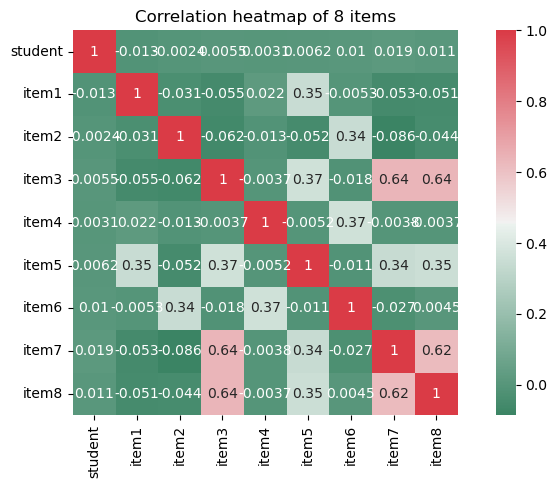

In [48]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

student_responses = pd.read_csv('8items.csv')
student_responses.head()

f, ax = plt.subplots(figsize=(10, 5))
corr = student_responses.corr()
plt.title("Correlation heatmap of 8 items")
sns.heatmap(corr, mask=np.zeros_like(corr),
           cmap=sns.diverging_palette(150, 10, as_cmap=True), annot=True,
           square=True, ax=ax)

# Mapping items to skills
Second, our goal is the mapping of items to skills, so therefore we have to uncover the latent skills. As the latent variables "concepts"/"skills" that relate observed variables (Barnes et al., 2005) based on domain knowledge were not given in this dataset, non-negative matrix factorization(NMF) is used for inferring the Q-matrix based on a students' test performance data. 

In this case, I assumed the number of skills is 8. Since each concept or skill is considered a required condition for the success of each test item (Desmarais et al., 2006), so the number of concepts or skills can be thought of the similar number of items.

# Q-matrix and Knowledge Structures
The Q-matrix using NMF shows the relationship between items and skills. Also, the knowledge structure graph represents the items and their associated skills. But, this is a possible knowledge relationship and we do not know a prerequisite knowledge relationship among the skills, since the q-matrix is a domain-independent.


In [68]:
# Code with ChatGPT
# building q-matrix
student_responses = pd.read_csv('8items.csv')

n_skills = 8
student_responses = student_responses.drop(columns=['student'])

nmf_model = NMF(n_components=n_skills, init='random', random_state=0)
W = nmf_model.fit_transform(student_responses)
H = nmf_model.components_
threshold = H.max() * 0.1
q_matrix = pd.DataFrame(np.where(H > threshold, 1, 0), 
                        index=[f'Skill{i+1}' for i in range(n_skills)], 
                        columns=response_data.columns)
q_matrix.to_csv('new_q_matrix.csv', index=False)


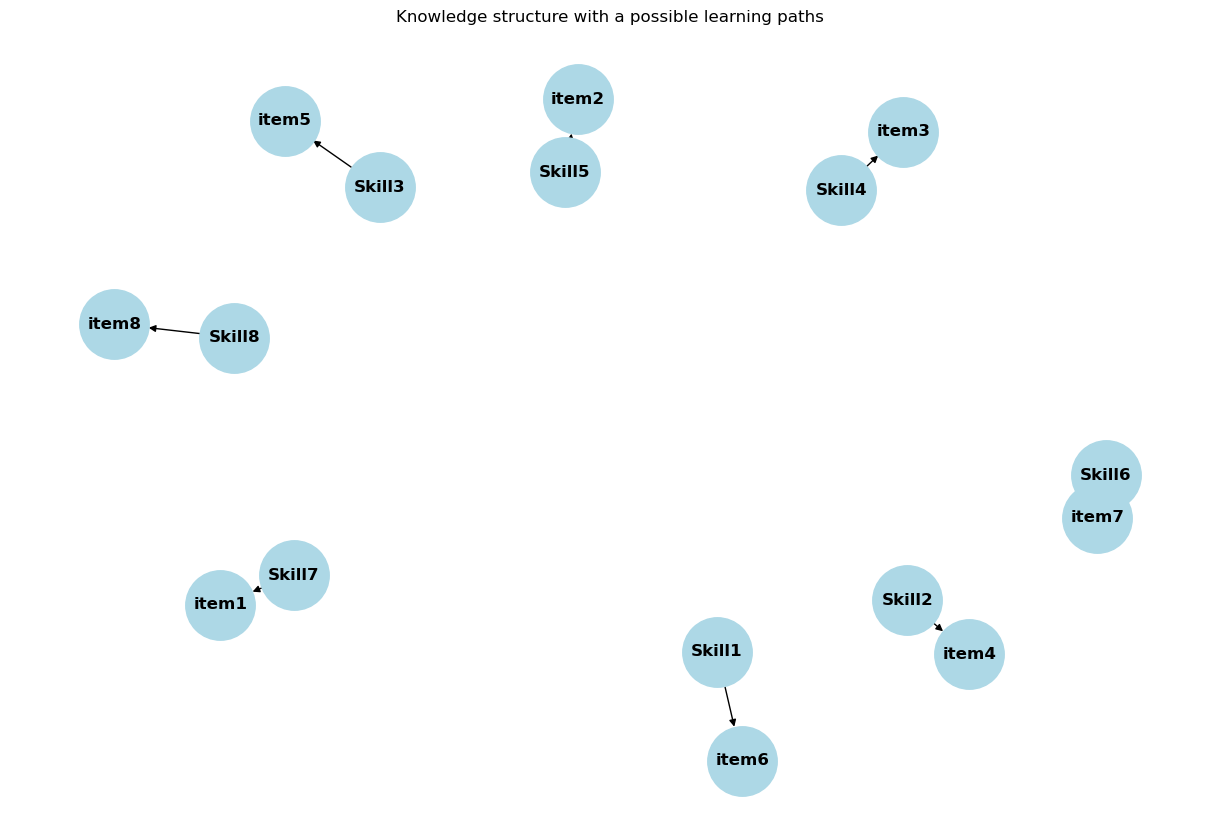

,item1,item2,item3,item4,item5,item6,item7,item8
Skill1,0,0,0,0,0,1,0,0
Skill2,0,0,0,1,0,0,0,0
Skill3,0,0,0,0,1,0,0,0
Skill4,0,0,1,0,0,0,0,0
Skill5,0,1,0,0,0,0,0,0
Skill6,0,0,0,0,0,0,1,0
Skill7,1,0,0,0,0,0,0,0
Skill8,0,0,0,0,0,0,0,1


In [88]:
# creating a knowledge structure graph
def create_knowledge_graph(q_matrix):
    G = nx.DiGraph() 
    for skill in q_matrix.index:
        for item in q_matrix.columns:
            if q_matrix.loc[skill, item] > 0.1:  
                G.add_edge(skill, item)
    return G

knowledge_graph = create_knowledge_graph(q_matrix)
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(knowledge_graph)
nx.draw(knowledge_graph, pos, with_labels=True, node_size=2500, node_color="lightblue", font_size=12, font_weight='bold', arrows=True)
plt.title("Knowledge structure with a possible learning paths")
plt.show()

q_matrix  

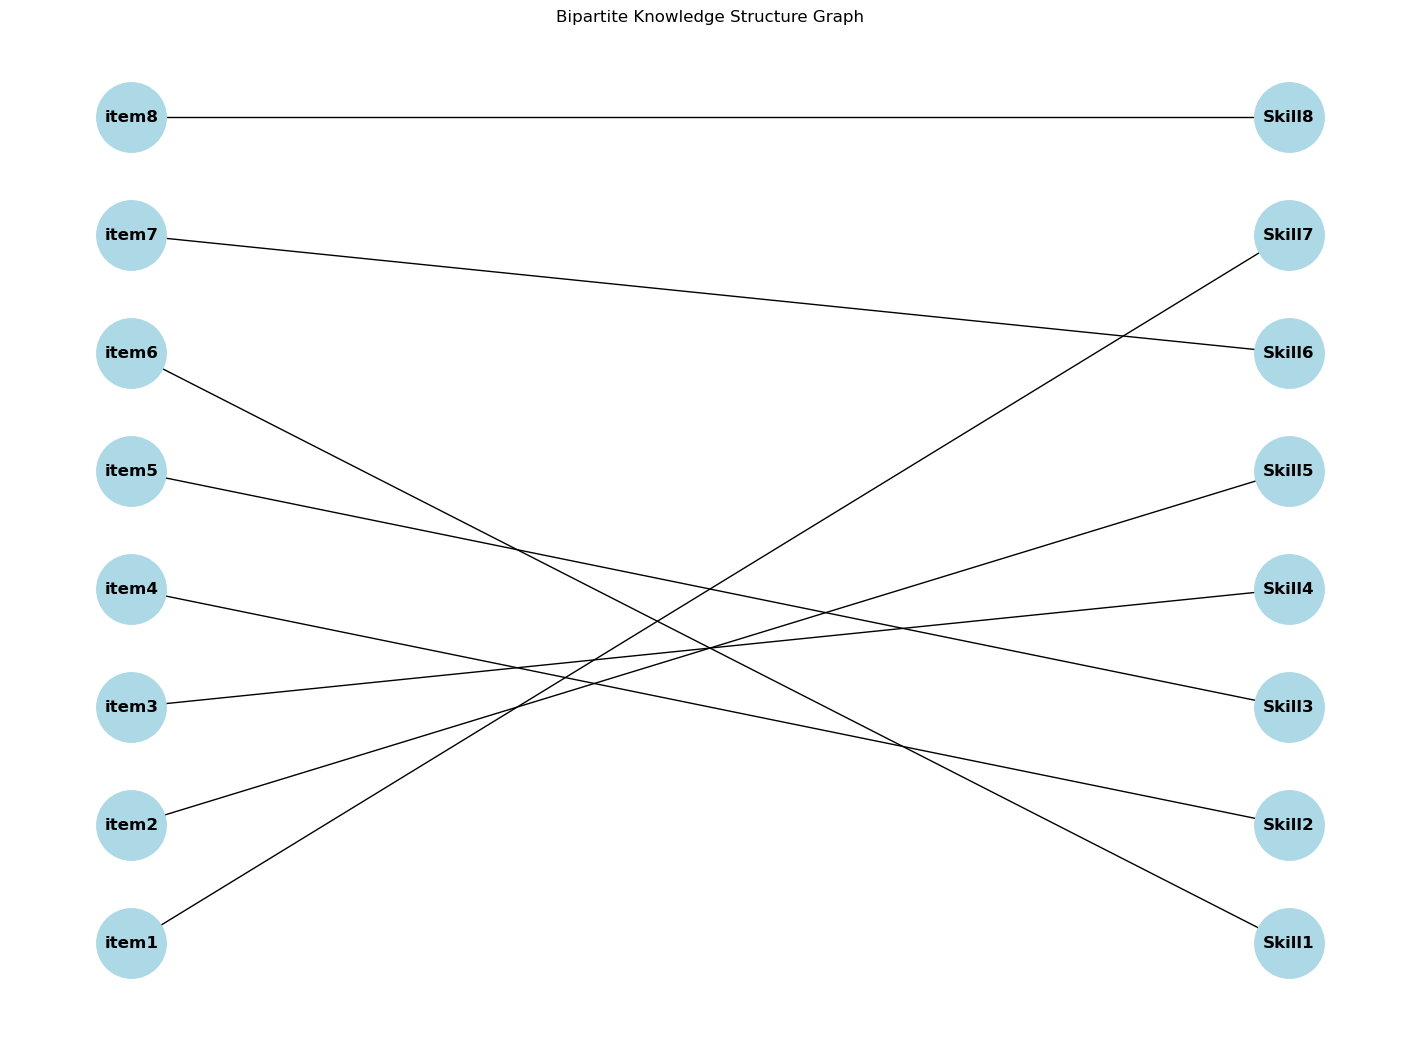

In [89]:
# creating a bipartite graph
def create_bipartite_knowledge_graph(q_matrix):
    B = nx.Graph()
    B.add_nodes_from(q_matrix.index, bipartite=0)  # Skills
    B.add_nodes_from(q_matrix.columns, bipartite=1)  # Items
    for skill in q_matrix.index:
        for item in q_matrix.columns:
            if q_matrix.loc[skill, item] > 0.1:
                B.add_edge(skill, item)

    return B

bipartite_knowledge_graph = create_bipartite_knowledge_graph(q_matrix)
plt.figure(figsize=(14, 10))
pos = {node: [0, i] for i, node in enumerate(q_matrix.columns)}  
pos.update({node: [1, i] for i, node in enumerate(q_matrix.index)}) 

nx.draw(bipartite_knowledge_graph, pos, with_labels=True, node_size=2500, node_color="lightblue", font_size=12, font_weight='bold')
plt.title("Bipartite Knowledge Structure Graph")
plt.show()


# Discussion
It can be seen that each skill corresponds to each item in the knowledge structure graph using the q-matrix. The directed edges indicate the possible learning path (Heller et al., 2006) or knowledge states(But, in this graph, the arrows show no gradual learning process or connection among skills at all.) 

The matrix and graph can help to define the most appropriate knowledge state/skill for students and teachers. Consequently, it hepls for each student reaches the highest standards for the items by assessing students' right skills per item.

However, the matrix was based on the observed student's current knowledge state(test scores). Thus, we have to ensure its accuracy and validity. Moreover, domain experts is needed to exactly define the latent variables behind items and ensure its accuracy and effectiveness.

# References

1. Barnes, T., Bitzer, D., Vouk, M. (2005) Experimental Analysis of the Q-Matrix Method in Knowledge Discovery. Lecture Notes in Computer Science 3488: Foundations of Intelligent Systems, 603-611.

2. Desmarais, M.C., Meshkinfam, P., Gagnon, M. (2006) Learned Student Models with Item to Item Knowledge Structures. User Modeling and User-Adapted Interaction, 16, 5, 403-434

3. Desmarais, M. C., & Naceur, R. (2013) A matrix factorization method for mapping items to skills and for enhancing expert-based Q-Matrices. Proceedings of the International Conference on Artificial Intelligence in Education, 441-450.

4. Heller, J., C. Steiner, C. Hockemeyer, and D. Albert. (2006) Competence–Based Knowledge Structures for Personalised Learning. International Journal on E–Learning 5(1), 75–88.